# Maximum a Posteriori Estimation for Pooled Calibration with IMPALA
The main IMPALA codebase estimates calibration parameters theta using Bayesian Markov Chain Monte Carlo. This algorithm provides a posterior distribution for theta. This is more than we need, however, if we only care about the single "best" configuration of theta fitting our observed data. In that case, an often faster and more direct estimate of the "best" configuration of theta can be obtained using Maximum a Posteriori (MAP) estimation, a popular Bayesian approach to estimating the mode (i.e., highest point) of the posterior distribution.

In as-yet unpublished work, we developed a MAP estimation algorithm for IMPALA that optimizes the posterior likelihood of the observed data as a function of theta, after integrating out nuisances parameters such as the experimental noise. We provide the corresponding code as part of IMPALA, which should be viewed as experimental for now. The integrated posterior is approximated using Monte Carlo Integration, an importance sampling-based methodology. The number of samples used for the Monte Carlo integration directly relates to the degree of approximation, where a larger number of samples is generally associated with a better approximation. In practice, we have found that 100 Monte Carlo samples provides a reasonable approximation in many settings. This approximated posterior is then maximized with respect to theta (and any discrepancy basis coefficients if applicable) using one of three different global maximization methods. Global maximization is essential for this problem, since calibration posterior distributions often have multiple local modes. We note that the posterior may not even have a unique local mode. Due to this, there are no guarantees of uniqueness for the resulting MAP estimate. 

Below, we describe how to implement the MAP estimation methods with IMPALA. Then, we illustrate the methods using the Friedman function. 

## IMPALA Code for MAP Estimation
The current implementation of the IMPALA MAP estimation uses the function **get_map_impalapool**. Arguments are as follows:

1. **setup**: the IMPALA modeling object generated as usual (see other tutorials for details)
2. **n_samples**: number of Monte Carlo Integration samples used to approximate the integrated posterior. Generally, 100-1000 seem to do well. 
3. **theta_init**: 1 x p array with the initial values for theta. This can be obtained using the IMPALA theta posterior as below or defined manually by the user.
4. **disc_init**: (optional) if the model includes discrepancy, this is a 1 x d array containing initial values for the discrepancy basis coefficients, where d is the number of basis elements.
5. **optmethod**: defines the global optimization algorithm used. Options include 'bh for basinhopping (default), 'pso' for particle swarm optimization, and 'grid' for optimization across Latin Hypercube grid values.
6. **niter**: number of iterations for basinhopping, swarmsize for particle swarm, and number of parallel runs for Latin Hypercube grid optimization
7. **T**: hyperparameter for basinhopping algorithm related to the size of the jumps between iterations. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html for details. 
8. **n_scores**: hyperparameter for Latin Hypercube sampling corresponding to number of cores used for parallel runs



## An Illustrative Example: MAP Estimation for the Friedman Function
In this section, we illustrate the MAP estimation method for the Friedman function. Additional details about the Friedman function are provided in **ex_friedman**. Here, we run the example without additional exposition. 

### Generate Data and Initialize IMPALA Model Structure

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from impala import superCal as sc


### Generating Data
def f(x):
    out = (
        10.0 * np.sin(np.pi * tt * x[0])
        + 20.0 * (x[1] - 0.5) ** 2
        + 10 * x[2]
        + 5.0 * x[3]
    )
    return out


p = 9
nt = 50
tt = np.linspace(0, 1, nt)
xx_true = np.random.rand(1, p)
yobs = (
    np.apply_along_axis(f, 1, xx_true).reshape(nt)
    + np.random.normal(size=50) * 0.1
)

### Setting up the IMPALA Model Structure
input_names = [str(v) for v in list(range(p))]
bounds = dict(
    zip(input_names, np.concatenate((np.zeros((p, 1)), np.ones((p, 1))), 1))
)
setup = sc.CalibSetup(bounds, constraint_func="bounds")
model = sc.ModelF(f, input_names)
setup.addVecExperiments(
    yobs=yobs, model=model, sd_est=[1.0], s2_df=[0], s2_ind=[0] * nt
)
setup.setTemperatureLadder(1.05 ** np.arange(40))
setup.setMCMC(nmcmc=15000, decor=100)

### (Optional) Get good initial value for optimal theta
The following steps are optional. It is used to obtain a really good initialization for the MAP estimation algorithm. However, this step could be replaced with a user-defined initialization in the next step.

In [2]:
### Run Pooled Calibration
out = sc.calibPool(setup)  # pooled calibration (takes less than a minute)

[2024-05-06 15:33:21 | 14999/14999 (100%) | WALL: 0:00:41 | ETA: 0:00:00 | 361.81it/s]
Calibration MCMC Complete. Time: 41.468501 seconds.


In [3]:
### Identify Highest-Likelihood MCMC Sample of Theta
mcmc_use = np.arange(5000, 15000, 2)  # burn and thin index
mat = np.vstack(out.theta[mcmc_use, 0, :])
mat_trans = np.array(
    pd.DataFrame(sc.tran_unif(mat, setup.bounds_mat, setup.bounds.keys()))
)

from impala.superCal.map import *

POST_pool = eval_partialintlogposterior_impalapool(
    setup, n_samples=1000, theta=mat_trans
)

### Obtain MAP Estimate
This function uses the default basinhopping algorithm with 100 iterations.

In [4]:
MAP_pool = get_map_impalapool(
    setup,
    n_samples=1000,
    theta_init=mat_trans[np.argmax(POST_pool), :].reshape(1, -1),
    niter=100,
)

basinhopping step 0: f -86.444
basinhopping step 1: f -86.444 trial_f 1e+06 accepted 0  lowest_f -86.444
basinhopping step 2: f -86.444 trial_f 1e+06 accepted 0  lowest_f -86.444
basinhopping step 3: f -86.4332 trial_f -86.4332 accepted 1  lowest_f -86.444
basinhopping step 4: f -86.4463 trial_f -86.4463 accepted 1  lowest_f -86.4463
found new global minimum on step 4 with function value -86.4463
basinhopping step 5: f -86.4463 trial_f 1e+06 accepted 0  lowest_f -86.4463
basinhopping step 6: f -86.4322 trial_f -86.4322 accepted 1  lowest_f -86.4463
basinhopping step 7: f -86.4502 trial_f -86.4502 accepted 1  lowest_f -86.4502
found new global minimum on step 7 with function value -86.4502
basinhopping step 8: f -86.4487 trial_f -86.4487 accepted 1  lowest_f -86.4502
basinhopping step 9: f -86.4455 trial_f -86.4455 accepted 1  lowest_f -86.4502
basinhopping step 10: f -86.4437 trial_f -86.4437 accepted 1  lowest_f -86.4502
basinhopping step 11: f -86.4452 trial_f -86.4452 accepted 1  lo

### Evaluate Results
Now, we evaluate the results. First, we compare the prediction error we get from the MAP estimation vs. the theta posterior median and the "best" posterior draw in terms of the joint IMPALA posterior. In this example, the posterior median provides a poorly-predictive value of theta due to the unusual structure of the posterior distribution for theta. The best posterior draw and the MAP estimate produce very similar prediction error, albeit with different values of poorly-identified theta.  

In [8]:
BEST = dict()
SSE = dict()
MAPE = dict()
n_exp = len(np.unique(setup.s2_ind))
s2_inds = setup.s2_ind[0]
THETA_Y = sc.post_process.get_outcome_predictions_impala(
    setup, theta_input=mat_trans
)["outcome_draws"]

### Parent_Median
pred_median = sc.post_process.get_outcome_predictions_impala(
    setup, theta_input=np.median(mat_trans, axis=0).reshape(1, -1)
)["outcome_draws"]
median_sse = sum([
    (
        (
            pred_median[0][0, np.where(s2_inds == i)]
            - setup.ys[0][np.where(s2_inds == i)]
        )
        ** 2
    ).mean(axis=1)
    for i in range(n_exp)
])
median_mape = 100 * np.mean([
    (
        np.abs(
            pred_median[0][0, np.where(s2_inds == i)]
            - setup.ys[0][np.where(s2_inds == i)]
        )
        / setup.ys[0][np.where(s2_inds == i)]
    ).mean(axis=1)
    for i in range(n_exp)
])
BEST["parent_median"] = np.median(mat_trans, axis=0)
SSE["parent_median"] = median_sse
MAPE["parent_median"] = median_mape

### Best Draw
parent_sse = sum([
    (
        (
            THETA_Y[0][:, np.where(s2_inds == i)[0]]
            - setup.ys[0][np.where(s2_inds == i)]
        )
        ** 2
    ).mean(axis=1)
    for i in range(n_exp)
])
pred_minsse = np.hstack([
    THETA_Y[0][
        np.where(parent_sse == parent_sse.min()), np.where(s2_inds == i)[0]
    ]
    for i in range(n_exp)
]).reshape(1, -1)
parent_mape = 100 * np.mean([
    (
        np.abs(
            pred_minsse[0, np.where(s2_inds == i)]
            - setup.ys[0][np.where(s2_inds == i)]
        )
        / setup.ys[0][np.where(s2_inds == i)]
    ).mean(axis=1)
    for i in range(n_exp)
])
BEST["parent_minsse"] = mat_trans[
    np.where(parent_sse == parent_sse.min())[0], :
].flatten()
SSE["parent_minsse"] = np.array([parent_sse.min()])
MAPE["parent_minsse"] = parent_mape

### MAP
pred_map = sc.post_process.get_outcome_predictions_impala(
    setup, theta_input=np.array(pd.DataFrame(MAP_pool.values())).reshape(1, -1)
)["outcome_draws"]
map_sse = sum([
    (
        (
            pred_map[0][0, np.where(s2_inds == i)]
            - setup.ys[0][np.where(s2_inds == i)]
        )
        ** 2
    ).mean(axis=1)
    for i in range(n_exp)
])
map_mape = 100 * np.mean([
    (
        np.abs(
            pred_map[0][0, np.where(s2_inds == i)]
            - setup.ys[0][np.where(s2_inds == i)]
        )
        / setup.ys[0][np.where(s2_inds == i)]
    ).mean(axis=1)
    for i in range(n_exp)
])
BEST["map"] = np.array(pd.DataFrame(MAP_pool.values())).flatten()
SSE["map"] = map_sse
MAPE["map"] = map_mape

BEST_df = pd.DataFrame(
    BEST.values(), columns=np.array(pd.DataFrame(setup.bounds.keys())).flatten()
)
BEST_df["method"] = np.array(pd.DataFrame(BEST.keys())).flatten()
BEST_df["sse"] = np.array(pd.DataFrame(SSE.values())).flatten()
BEST_df["mape"] = np.array(pd.DataFrame(MAPE.values())).flatten()
print(BEST_df)

          0         1         2         3         4         5         6  \
0  0.311445  0.562992  0.459687  0.447656  0.499682  0.508683  0.504087   
1  0.311437  0.716736  0.409231  0.740287  0.732046  0.949297  0.361470   
2  0.311502  0.772080  0.270419  0.909654  0.496428  0.099681  0.912922   

          7         8         method       sse       mape  
0  0.499567  0.516951  parent_median  3.316394  14.271002  
1  0.991387  0.081685  parent_minsse  0.008930   0.602862  
2  0.915886  0.233925            map  0.008931   0.603007  


## Exploring the Identifiability of the Posterior Mode
As mentioned earlier, the proposed MAP estimation algorithm is not guaranteed to identify a unique posterior mode; indeed, many calibration problems do not have a unique posterior mode. The degree to which the identified posterior mode can be viewed as "unique" can be roughly explored using various posterior visualization and summarization diagnostics. 

First, we visualize the integrated posterior distribution of the first three elements of theta. Some unidentifiability or weak identifiability is evident, as the posterior distribution has a ridge along the maximum rather than a unique maximizer.

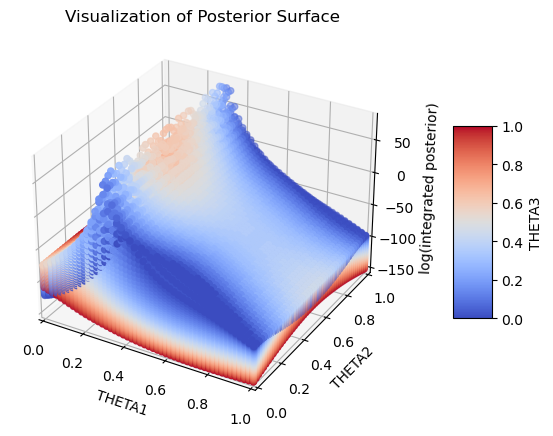

In [10]:
theta_grid = np.array([
    (
        np.linspace(0, 1, 50)[x],
        np.linspace(0, 1, 50)[y],
        np.linspace(0, 1, 50)[z],
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
    )
    for x in range(50)
    for y in range(50)
    for z in range(50)
])
GRID_pool = eval_partialintlogposterior_impalapool(
    setup, n_samples=1000, theta=theta_grid
)

from matplotlib import cm

X = theta_grid[:, 0]
Y = theta_grid[:, 1]
Z = theta_grid[:, 2]
X0 = X[~np.isnan(X + Y + Z)]
Y0 = Y[~np.isnan(X + Y + Z)]
Z0 = Z[~np.isnan(X + Y + Z)]
P0 = GRID_pool.flatten()[~np.isnan(X + Y + Z)]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 5))
surf = ax.scatter3D(X0, Y0, P0, c=Z0, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5, label="THETA3")
ax.set_xlim(np.nanmin(X0), np.nanmax(X0))
ax.set_ylim(np.nanmin(Y0), np.nanmax(Y0))
ax.set_zlim(np.nanmin(P0), np.nanmax(P0))
ax.set_xlabel("THETA1")
ax.set_ylabel("THETA2")
ax.set_zlabel("log(integrated posterior)")
ax.set_title("Visualization of Posterior Surface")
plt.show()

Next, we summarize the theta values associated with quantiles of the posterior surface. Variability approaching zero as the integrated posterior quantiles approach 1 indicates good identifiability of the posterior mode. This evaluation can be implemented either using IMPALA posterior draws for theta or across a Latin Hypercube sampled grid of theta values. The magnitude of the variances obtained by the two methods cannot be very easily compared to each other. In both cases, the absolute value of the variances can be difficult to directly interpret; rather, the relative orderings of the parameter variances as the posterior quantiles approach 1 can provide a sense of the relative identifiability of the posterior modes for each parameter. The horizontal dashed line indicates the uncertainty we would see if the posterior distribution was a Uniform(0,1) prior, indicating a total lack of information about a given parameter.

Here, we use the posterior samples of theta to evaluate the identifiability of the posterior mode. The posterior mode for theta1 appears well-identified, and theta3 appears to be slightly better identified than some other parameters. All other parameters exhibit very worrisome behavior indicating at best weak identifiability. 

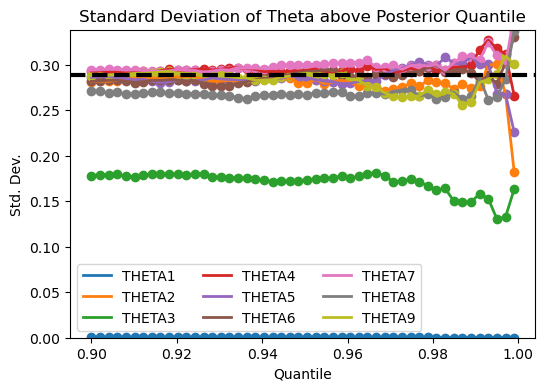

In [11]:
### Variability in Theta by Integrated Posterior Quantile using Posterior Draws
mat_sort = mat[np.argsort(POST_pool), :]
mat_trans_sort = mat_trans[np.argsort(POST_pool), :]
POST_sort = np.sort(POST_pool)
QUANTS = np.linspace(0.9, 0.999, 50)
THETA_VARS = np.empty((0, mat_sort.shape[1]))
for i in range(len(QUANTS)):
    THETA_VARS = np.append(
        THETA_VARS,
        mat_trans_sort[
            np.where(POST_sort >= np.quantile(POST_sort, QUANTS[i])), :
        ].var(axis=1),
        axis=0,
    )

KEYS = list([
    "THETA1",
    "THETA2",
    "THETA3",
    "THETA4",
    "THETA5",
    "THETA6",
    "THETA7",
    "THETA8",
    "THETA9",
])
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=False)
COL = sns.color_palette(n_colors=int(mat_trans_sort.shape[1]))
for i in range(mat_trans_sort.shape[1]):
    ax.plot(
        QUANTS,
        np.sqrt(THETA_VARS[:, i]),
        color=COL[i],
        label=KEYS[i],
        linewidth=2,
    )
    ax.scatter(QUANTS, np.sqrt(THETA_VARS[:, i]), color=COL[i])
ax.axhline(y=np.sqrt((1 / 12)), linestyle="--", color="black", linewidth=3)
ax.set_ylabel("Std. Dev.")
ax.title.set_text("Standard Deviation of Theta above Posterior Quantile")
ax.set_xlabel("Quantile")
ax.legend(loc="lower left", ncol=3)
ax.set_ylim(0, np.sqrt((1 / 12)) + 0.05)
plt.show()